In this notebook, stock price prediction based on LSTM and timeseries data is demonstrated.

Based on the model predictions, data is also extrapolated considering the previously predicted values.

Referred articles :
https://medium.com/@matthew1992/forecasting-stock-with-different-models-arima-lstm-fourier-ef096885cf75
https://medium.com/@redeaddiscolll/stock-market-time-series-lstm-failure-56089ce3c0b8
https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.preprocessing.sequence import TimeseriesGenerator
import math
from sklearn.metrics import mean_squared_error
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
!pip install pandas_ta
import pandas_ta as ta
import datetime
import seaborn as sns
from numpy.random import seed
seed(0)
from tqdm import tqdm
import time
import pickle

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=210642d9b48900a4c02e43c789ba2422a2ac7e0373606b143483b17bd732374f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
del df

In [3]:
# Getting the stock data
ticker='NAVINFLUOR'
start='2000-01-01'
df = pdr.get_data_yahoo(str(ticker+".NS"), start=start)
# For training the data we will not be using Open, High, Low, Adj Close, Volume as this will not be present for extrapolation
# For extrapolation, we will do it in one step at a time where close price will be predicted based on previous features
# and then features for next step prediction will be generated based on predicted close price
df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)
df.head()
df

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2007-06-01,64.519997
2007-06-04,67.599998
2007-06-05,71.000000
2007-06-06,73.900002
2007-06-07,74.769997
...,...
2023-12-20,3721.300049
2023-12-21,3743.899902
2023-12-22,3763.500000


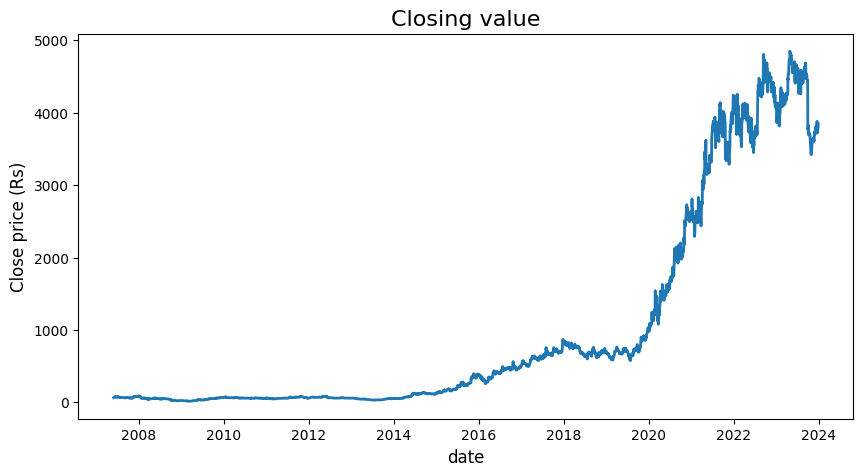

In [4]:
# Plotting close value data
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Close'], lw=2)
plt.xlabel("date")
plt.xlabel("date", fontsize=12)
plt.ylabel("Close price (Rs)", fontsize=12)
plt.title("Closing value", fontsize=16)
plt.show()

In [5]:
## Featurizing with technical indicators
def get_technical_indicators(dataset): #function to generate feature technical indicators


    dataset['ma7'] = dataset['Close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window = 21).mean()

    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    dataset['20sd'] = dataset['Close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['Close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['Close'].rolling(window = 20).mean()) - (dataset['20sd']*2)


    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()

    dataset['momentum'] = (dataset['Close']/100)-1



    return dataset

In [6]:
df_TI=df.copy()
df_TI=get_technical_indicators(df_TI)
# Also as first 21 rows has Nan values lets ignore these rows
df_TI=df_TI.iloc[30:]
df_TI.head()

,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,
2007-07-13,74.800003,74.480001,74.214762,74.282599,74.392471,0.109872,1.357613,76.760226,71.329774,74.861111,-0.2520
2007-07-16,75.000000,75.037144,74.090477,74.340689,74.486385,0.145696,1.283481,76.761962,71.628038,74.953704,-0.2500
2007-07-17,73.419998,74.697144,74.158096,74.266649,74.321661,0.055012,1.293907,76.733815,71.558186,73.931233,-0.2658
2007-07-18,74.580002,74.508572,74.166667,74.291689,74.361542,0.069852,1.293546,76.732092,71.557909,74.363746,-0.2542
2007-07-19,74.650002,74.564286,74.169048,74.320156,74.406049,0.085892,1.273370,76.661741,71.568260,74.554583,-0.2535


In [7]:
df_TI.tail()

,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
Date,,,,,,,,,,,
2023-12-20,3721.300049,3823.307129,3762.211891,3762.638994,3799.199119,36.560125,71.150652,3911.286289,3626.683681,3770.777392,36.213000
2023-12-21,3743.899902,3819.664272,3767.790458,3761.250913,3790.691547,29.440634,61.039827,3897.737138,3653.577828,3752.859065,36.438999
2023-12-22,3763.500000,3815.899972,3775.078555,3761.417512,3786.508232,25.090720,59.036874,3896.501226,3660.353730,3759.953022,36.635000
2023-12-26,3797.850098,3806.642857,3779.352365,3764.116222,3788.253135,24.136913,58.174240,3898.030963,3665.334003,3785.217739,36.978501
2023-12-27,3851.000000,3803.821429,3784.983317,3770.552057,3797.906498,27.354441,56.164553,3901.926592,3677.268379,3829.072580,37.510000


## Train and Test Data

In [8]:
# Define the parameters of number of features and look back period for time series generator
look_back = 30
n_features=10
# Lets validate the predictions on the last two months of data
test_prediction_start_date="2023-11-01"

In [9]:
# train / test split
train_data = df_TI.query('Date <  @test_prediction_start_date').reset_index(drop = False)
test_data_actual  = df_TI.query('Date >= @test_prediction_start_date').reset_index(drop = False)

# Lets add additinal samples = look_back from train_data at test top
test_add=train_data[-look_back:]
test_data = pd.concat([test_add,test_data_actual.loc[:]]).reset_index(drop=True)

In [10]:
test_data

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2023-09-15,4543.549805,4585.699986,4564.114304,4549.347868,4569.850065,20.502197,73.393628,4718.367285,4424.792773,4538.598971,44.435498
1,2023-09-18,4489.149902,4557.528530,4567.654785,4544.888759,4557.434655,12.545896,71.539356,4715.983741,4429.826318,4505.632925,43.891499
2,2023-09-20,4515.350098,4536.514230,4570.164318,4542.700710,4550.960108,8.259397,70.186345,4714.560215,4433.814834,4512.111040,44.153501
3,2023-09-21,4493.799805,4509.192801,4570.359538,4539.078421,4542.166215,3.087794,71.224600,4715.639215,4430.740815,4499.903550,43.937998
4,2023-09-22,4469.350098,4503.957101,4568.245257,4533.913360,4530.963735,-2.949625,74.715476,4718.860982,4419.999076,4479.534582,43.693501
...,...,...,...,...,...,...,...,...,...,...,...,...
63,2023-12-20,3721.300049,3823.307129,3762.211891,3762.638994,3799.199119,36.560125,71.150652,3911.286289,3626.683681,3770.777392,36.213000
64,2023-12-21,3743.899902,3819.664272,3767.790458,3761.250913,3790.691547,29.440634,61.039827,3897.737138,3653.577828,3752.859065,36.438999
65,2023-12-22,3763.500000,3815.899972,3775.078555,3761.417512,3786.508232,25.090720,59.036874,3896.501226,3660.353730,3759.953022,36.635000
66,2023-12-26,3797.850098,3806.642857,3779.352365,3764.116222,3788.253135,24.136913,58.174240,3898.030963,3665.334003,3785.217739,36.978501


In [11]:
train_data

,Date,Close,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum
0,2007-07-13,74.800003,74.480001,74.214762,74.282599,74.392471,0.109872,1.357613,76.760226,71.329774,74.861111,-0.252000
1,2007-07-16,75.000000,75.037144,74.090477,74.340689,74.486385,0.145696,1.283481,76.761962,71.628038,74.953704,-0.250000
2,2007-07-17,73.419998,74.697144,74.158096,74.266649,74.321661,0.055012,1.293907,76.733815,71.558186,73.931233,-0.265800
3,2007-07-18,74.580002,74.508572,74.166667,74.291689,74.361542,0.069852,1.293546,76.732092,71.557909,74.363746,-0.254200
4,2007-07-19,74.650002,74.564286,74.169048,74.320156,74.406049,0.085892,1.273370,76.661741,71.568260,74.554583,-0.253500
...,...,...,...,...,...,...,...,...,...,...,...,...
4015,2023-10-25,3476.300049,3618.371408,3827.885707,3887.428017,3676.669902,-210.758115,278.712079,4354.151661,3239.303344,3504.718515,33.763000
4016,2023-10-26,3429.800049,3580.464286,3779.254767,3853.529649,3638.689925,-214.839724,245.423338,4237.016672,3255.323318,3454.772871,33.298000
4017,2023-10-27,3431.949951,3542.628557,3731.207136,3822.301523,3606.883775,-215.417748,192.449816,4080.424619,3310.625356,3439.557591,33.319500
4018,2023-10-30,3424.149902,3506.735700,3682.602365,3792.808811,3578.770872,-214.037939,124.681831,3898.213651,3399.486325,3429.285799,33.241499


## Data Processing


In [12]:
X_train = train_data.drop(['Date','Close'],axis=1)
y_train = train_data['Close']

X_test = test_data.drop(['Date','Close'],axis=1)
y_test = test_data['Close']

# Lets reshape the outputs to match with time series generator requirement
y_train=y_train.values.reshape((len(y_train),1))
y_test=y_test.values.reshape((len(y_test),1))

In [13]:
# Min max scaling of X train and test data
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
print('Shape of X_train is ',X_train.shape)
print('Shape of y_train is ',y_train.shape)
print('Shape of X_test is ',X_test.shape)
print('Shape of y_test is ',y_test.shape)

Shape of X_train is  (4020, 10)
Shape of y_train is  (4020, 1)
Shape of X_test is  (68, 10)
Shape of y_test is  (68, 1)


## Time Series Generator
https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

In [14]:
# Following few cells defines how time series generator works and experimenting with different parameters
from numpy import array
from numpy import hstack
# define dataset
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
out_seq = array([25, 45, 65, 85, 105, 125, 145, 165, 185, 205])
# reshape series
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2))
print('Shape of dataset is ',dataset.shape)
print('Shape of output is',out_seq.shape)

Shape of dataset is  (10, 2)
Shape of output is (10, 1)


In [14]:
dataset

array([[ 10,  15],
       [ 20,  25],
       [ 30,  35],
       [ 40,  45],
       [ 50,  55],
       [ 60,  65],
       [ 70,  75],
       [ 80,  85],
       [ 90,  95],
       [100, 105]])

In [15]:
out_seq

array([[ 25],
       [ 45],
       [ 65],
       [ 85],
       [105],
       [125],
       [145],
       [165],
       [185],
       [205]])

In [16]:
# define generator
n_input = 4
generator = TimeseriesGenerator(dataset, out_seq, length=n_input, batch_size=1,sampling_rate = 1,stride = 1)
# print each sample
for i in range(len(generator)):
 x, y = generator[i]
 print('%s => %s' % (x, y))

[[[10 15]
  [20 25]
  [30 35]
  [40 45]]] => [[105]]
[[[20 25]
  [30 35]
  [40 45]
  [50 55]]] => [[125]]
[[[30 35]
  [40 45]
  [50 55]
  [60 65]]] => [[145]]
[[[40 45]
  [50 55]
  [60 65]
  [70 75]]] => [[165]]
[[[50 55]
  [60 65]
  [70 75]
  [80 85]]] => [[185]]
[[[60 65]
  [70 75]
  [80 85]
  [90 95]]] => [[205]]


In [15]:
# Time series generator
train_generator = TimeseriesGenerator(X_train, y_train,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)
test_generator = TimeseriesGenerator(X_test, y_test,
                                      length        = look_back,
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = 1)

In [16]:
x, y = test_generator[0]
print('Shape of variable array is ',x.shape)
print('Shape of output array is ',y.shape)
print('%s => %s' % (x, y))

Shape of variable array is  (1, 30, 10)
Shape of output array is  (1, 1)
[[[9.54128730e-01 9.63695071e-01 9.79017976e-01 9.62707544e-01
   5.78649652e-01 1.91047540e-01 9.39423293e-01 9.56573377e-01
   9.43184150e-01 9.36572766e-01]
  [9.48246800e-01 9.64445328e-01 9.78054722e-01 9.60082747e-01
   5.59907883e-01 1.86190814e-01 9.38946960e-01 9.57664654e-01
   9.36309627e-01 9.25320750e-01]
  [9.43859215e-01 9.64977119e-01 9.77582061e-01 9.58713934e-01
   5.49810658e-01 1.82646998e-01 9.38662480e-01 9.58529368e-01
   9.37660531e-01 9.30739970e-01]
  [9.38154762e-01 9.65018488e-01 9.76799576e-01 9.56854779e-01
   5.37628489e-01 1.85366404e-01 9.38878109e-01 9.57862918e-01
   9.35114861e-01 9.26282530e-01]
  [9.37061598e-01 9.64570454e-01 9.75683822e-01 9.54486413e-01
   5.23406817e-01 1.94509737e-01 9.39521955e-01 9.55534099e-01
   9.30867250e-01 9.21225379e-01]
  [9.36314418e-01 9.63626958e-01 9.74357886e-01 9.51887189e-01
   5.08904851e-01 2.03538936e-01 9.40336228e-01 9.53427960e-01
 

In [17]:
# Confirmation on processing
y_test[look_back]

array([3479.75])

In [18]:
train_generator[0][0].shape

(1, 30, 10)

In [ ]:
# Lets build a model for prediction
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
model.fit(train_generator, epochs = 100, batch_size = 16)

Epoch 1/100
3990/3990 [==============================] - 96s 23ms/step - loss: 1488347.2500 - mean_absolute_error: 572.8900
Epoch 2/100
3990/3990 [==============================] - 88s 22ms/step - loss: 266981.6250 - mean_absolute_error: 220.0627
Epoch 3/100
3990/3990 [==============================] - 87s 22ms/step - loss: 34704.4414 - mean_absolute_error: 90.2937
Epoch 4/100
3990/3990 [==============================] - 91s 23ms/step - loss: 21205.0840 - mean_absolute_error: 75.6906
Epoch 5/100
3990/3990 [==============================] - 87s 22ms/step - loss: 17687.6133 - mean_absolute_error: 69.2447
Epoch 6/100
3990/3990 [==============================] - 90s 23ms/step - loss: 15432.6191 - mean_absolute_error: 64.7493
Epoch 7/100
3990/3990 [==============================] - 88s 22ms/step - loss: 13681.9268 - mean_absolute_error: 60.5901
Epoch 8/100
3990/3990 [==============================] - 87s 22ms/step - loss: 12299.0449 - mean_absolute_error: 57.9553
Epoch 9/100
3990/3990 [====

In [ ]:
# Lets dump the model
pickle_path = '/content/drive/MyDrive/Stock Predictions/DataFiles/'

pickle_out=open(pickle_path+'LSTM_NAVINFLUOR_Model.pickle', 'wb')
pickle.dump(model,pickle_out)
pickle_out.close()

In [27]:
del model

In [28]:
# Lets use the model for predictions
pickle_path = '/content/drive/MyDrive/Stock Predictions/DataFiles/'

pickle_in=open(pickle_path+"LSTM_NAVINFLUOR_Model.pickle","rb")
model=pickle.load(pickle_in)
pickle_in.close()

In [22]:
model

In [29]:
train_predictions  = model.predict(train_generator)
test_predictions  = model.predict(test_generator)

38/38 [==============================] - 0s 7ms/step


## Extrapolating

In [30]:
train_samples=200
y_test_extpr=[]
for i in tqdm(range(len(X_test)-look_back), desc = 'tqdm() Progress Bar'):
  lst=train_data['Close'][-train_samples:].tolist()
  # append the predicted value from second step
  if i>0:
    lst.extend(y_test_extpr)
  # Creating a dataframe from dictionary of lists
  dict = {'Close': lst}
  df_extpr = pd.DataFrame(dict)
  df_extpr=get_technical_indicators(df_extpr)
  # Last observations with lookback period
  df_extpr=df_extpr.iloc[train_samples-look_back+i:]
  df_extpr.reset_index(inplace=True)
  df_extpr.drop(columns=['index'],inplace=True)
  X_test_extpr = df_extpr.drop(['Close'],axis=1)
  X_test_extpr=scaler.transform(X_test_extpr)
  X_test_extpr=X_test_extpr.reshape((1,look_back, n_features))
  predicted_value = model.predict(X_test_extpr)[0]
  y_test_extpr.append(predicted_value[0])

tqdm() Progress Bar:   0%|          | 0/38 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


tqdm() Progress Bar:   3%|▎         | 1/38 [00:01<00:41,  1.13s/it]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:   8%|▊         | 3/38 [00:01<00:12,  2.78it/s]

1/1 [==============================] - 0s 26ms/step


tqdm() Progress Bar:  13%|█▎        | 5/38 [00:01<00:07,  4.52it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  18%|█▊        | 7/38 [00:01<00:05,  6.04it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  24%|██▎       | 9/38 [00:01<00:04,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


tqdm() Progress Bar:  26%|██▋       | 10/38 [00:01<00:03,  7.54it/s]

1/1 [==============================] - 0s 27ms/step


tqdm() Progress Bar:  32%|███▏      | 12/38 [00:02<00:03,  8.48it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  37%|███▋      | 14/38 [00:02<00:02,  9.22it/s]

1/1 [==============================] - 0s 23ms/step


tqdm() Progress Bar:  42%|████▏     | 16/38 [00:02<00:02,  9.76it/s]

1/1 [==============================] - 0s 24ms/step


tqdm() Progress Bar:  47%|████▋     | 18/38 [00:02<00:01, 10.10it/s]

1/1 [==============================] - 0s 28ms/step


tqdm() Progress Bar:  53%|█████▎    | 20/38 [00:02<00:01,  9.79it/s]

1/1 [==============================] - 0s 35ms/step


tqdm() Progress Bar:  58%|█████▊    | 22/38 [00:03<00:01,  9.96it/s]

1/1 [==============================] - 0s 35ms/step


tqdm() Progress Bar:  63%|██████▎   | 24/38 [00:03<00:01,  9.05it/s]

1/1 [==============================] - 0s 36ms/step


tqdm() Progress Bar:  66%|██████▌   | 25/38 [00:03<00:01,  8.79it/s]

1/1 [==============================] - 0s 33ms/step


tqdm() Progress Bar:  68%|██████▊   | 26/38 [00:03<00:01,  8.54it/s]

1/1 [==============================] - 0s 33ms/step


tqdm() Progress Bar:  71%|███████   | 27/38 [00:03<00:01,  8.35it/s]

1/1 [==============================] - 0s 35ms/step


tqdm() Progress Bar:  74%|███████▎  | 28/38 [00:03<00:01,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


tqdm() Progress Bar:  76%|███████▋  | 29/38 [00:04<00:01,  7.66it/s]

1/1 [==============================] - 0s 34ms/step


tqdm() Progress Bar:  79%|███████▉  | 30/38 [00:04<00:01,  7.79it/s]

1/1 [==============================] - 0s 33ms/step


tqdm() Progress Bar:  82%|████████▏ | 31/38 [00:04<00:00,  7.78it/s]

1/1 [==============================] - 0s 32ms/step


tqdm() Progress Bar:  84%|████████▍ | 32/38 [00:04<00:00,  7.75it/s]

1/1 [==============================] - 0s 32ms/step


tqdm() Progress Bar:  87%|████████▋ | 33/38 [00:04<00:00,  7.50it/s]

1/1 [==============================] - 0s 38ms/step


tqdm() Progress Bar:  89%|████████▉ | 34/38 [00:04<00:00,  7.54it/s]

1/1 [==============================] - 0s 35ms/step


tqdm() Progress Bar:  92%|█████████▏| 35/38 [00:04<00:00,  7.55it/s]

1/1 [==============================] - 0s 36ms/step


tqdm() Progress Bar:  95%|█████████▍| 36/38 [00:04<00:00,  7.22it/s]

1/1 [==============================] - 0s 36ms/step


tqdm() Progress Bar:  97%|█████████▋| 37/38 [00:05<00:00,  7.24it/s]

1/1 [==============================] - 0s 32ms/step


tqdm() Progress Bar: 100%|██████████| 38/38 [00:05<00:00,  7.21it/s]


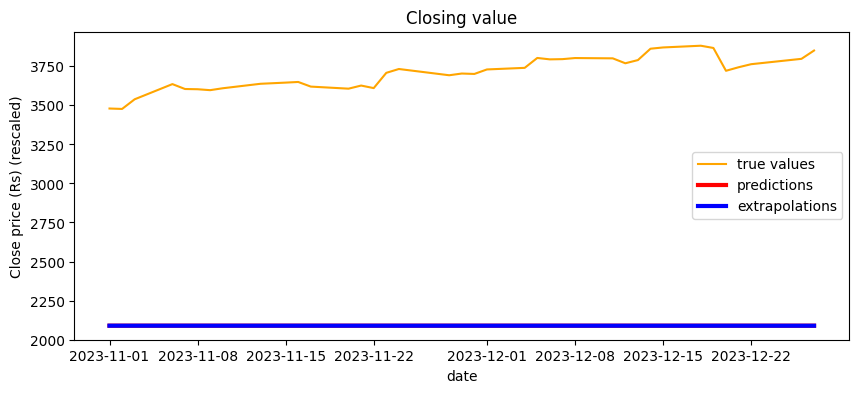

In [31]:
plt.figure(figsize=(10,4))
plt.plot(test_data.Date[look_back:], test_data['Close'][look_back:], c='orange',label='true values')
plt.plot(test_data.Date[look_back:],test_predictions.reshape(-1).tolist(), lw=3, c='r',linestyle = '-', label='predictions')
plt.plot(test_data.Date[look_back:],y_test_extpr, lw=3, c='b',linestyle = '-', label='extrapolations')
# plt.legend(loc="lower left")
plt.legend()
plt.xlabel("date", fontsize=10)
plt.ylabel("Close price (Rs) (rescaled)", fontsize=10)
plt.title("Closing value", fontsize=12);

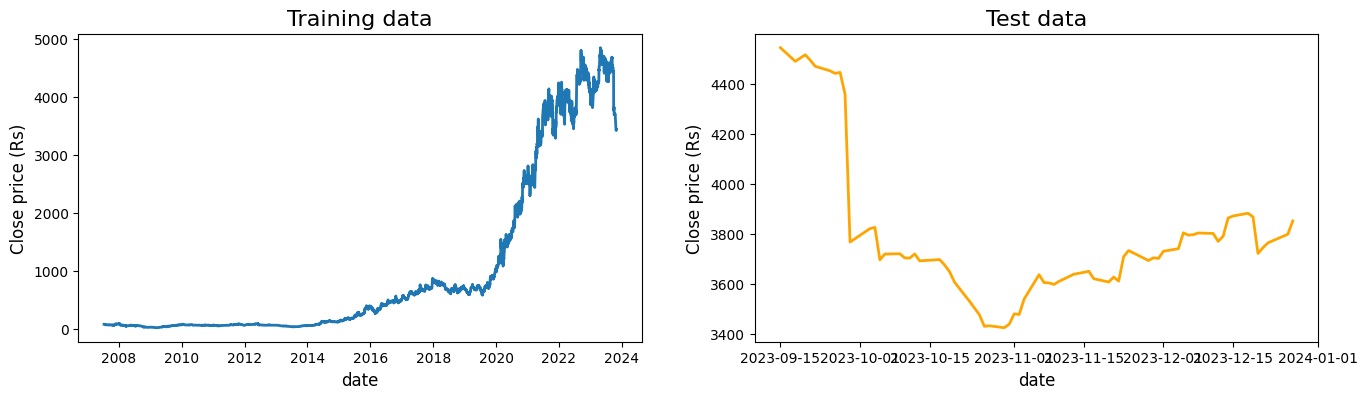

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(train_data.Date, train_data['Close'], lw=2)
ax1.set_xlabel("date", fontsize=12)
ax1.set_ylabel("Close price (Rs)", fontsize=12)
ax1.set_title("Training data", fontsize=16)
ax2.plot(test_data.Date, test_data['Close'], c='orange', lw=2)
ax2.set_xlabel("date", fontsize=12)
ax2.set_ylabel("Close price (Rs)", fontsize=12)
ax2.set_title("Test data", fontsize=16);